# Import Libraries

In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from MDAnalysis.analysis.distances import distance_array

import pandas as pd
import seaborn as sns
import sys
import time
import warnings
warnings.filterwarnings('ignore')

import lifelines # Used for Lifetime analysis #!pip install lifelines

#pd.set_option('display.max_rows', None)    # None means unlimited.




# Fucntions

In [ ]:

class ContactMatrix:
    """
    Class to calculate the contact matrix between two selections of atoms within a molecular universe.
    Author: Rubi Zarmiento Garcia
    """
    def __init__(self, universe, selection1, selection2, cutoff,group_by1='resnames',group_by2='resnames'):
        """
        Initializes the ContactMatrix class.
        
        Parameters:
        universe (MDAnalysis.Universe): The molecular universe containing the trajectory.
        selection1 (MDAnalysis.AtomGroup): The first selection of atoms.
        selection2 (MDAnalysis.AtomGroup): The second selection of atoms.
        cutoff (float): The cutoff distance for contacts in angstroms.
        """
        self.universe = universe
        self.selection1 = selection1
        self.selection2 = selection2
        self.cutoff = cutoff
        # Get the attributes to group by, if it is a list, then sum the attributes
        try:
            self.attributes1 = selection1.atoms.__getattribute__(group_by1)
        except:
            if len(selection1.atoms) == 1:
                self.attributes1 = selection1.atoms.__getattribute__(group_by1[0])   
            else: 
                if isinstance(group_by1, list):
                    list_attributes1 = []
                    list_attributes2 = []
                    for attribute in group_by1:
                        list_1 = selection1.atoms.__getattribute__(attribute)
                        #list_2 = selection2.atoms.__getattribute__(attribute)
                        #convert to string
                        list_1 = list(map(str, list_1))
                        list_attributes1.append(list_1)
                        #list_2 = list(map(str, list_2))
                        #list_attributes2.append(list_2)
                    #Sum the first element of each list, then the second element of each list, etc.
                    self.attributes1 = ['%s%s' % x for x in zip(*list_attributes1)]
                    #self.attributes2 = ['%s%s' % x for x in zip(*list_attributes2)]
        try:
            self.attributes2 = selection2.atoms.__getattribute__(group_by2)
        except:
            if len(selection2.atoms) == 1:
                self.attributes2 = selection2.atoms.__getattribute__(group_by2[0])
            else:
                if isinstance(group_by2, list):
                    list_attributes2 = []
                    for attribute in group_by2:
                        list_2 = selection2.atoms.__getattribute__(attribute)
                        #convert to string
                        list_2 = list(map(str, list_2))
                        list_attributes2.append(list_2)
                    #Sum the first element of each list, then the second element of each list, etc.
                    self.attributes2 = ['%s%s' % x for x in zip(*list_attributes2)]

        self.contacts_matrix = np.zeros((len(self.attributes1), len(self.attributes2)), dtype=int)
        self.distances = np.empty((selection1.n_atoms, selection2.n_atoms), dtype=float)
        self.indices1 = self.attributes1
        self.indices2 = self.attributes2
        self.n_frames = len(universe.trajectory)
        
    def calculate_contacts(self):
        """
        Calculates the contact matrix over the entire trajectory and groups by indices1 and indices2.
        """
        for frame in self.universe.trajectory:
            print(f"{frame.frame}/{len(self.universe.trajectory)}", end="\r", file=sys.stderr)
            distance_array(self.selection1.atoms.positions, self.selection2.atoms.positions, result=self.distances)
            contacts = (self.distances < self.cutoff) & (self.distances > 0)
            # Initialize dataframe with unique resnames instead of resnames
            df = pd.DataFrame(contacts, index=self.indices1, columns=self.indices2)
            # Group by resid and if one element is true, then the whole resid is true
            df = df.groupby(df.columns, axis=1).any()
            df = df.groupby(df.index, axis=0).any()
            
            self.contacts_matrix += df.values
        #Set column and row names
        self.contacts_matrix = pd.DataFrame(self.contacts_matrix, index=np.unique(self.attributes1), columns=np.unique(self.selection2.attributes2))
        return self.contacts_matrix
    
    def calculate_contact_matrix_per_observation(self, n_frames):
        """
        Save a contact matrix for every n_frames and stop if the largest value of saves_at is reached.
        """
        contact_matrix_list = []
        saves_at = np.arange(n_frames, self.n_frames + 1, n_frames)
        largest_save_point = saves_at[-1]  # Get the largest value from saves_at

        # Initialize contact matrix outside the loop
        contacts_matrix = np.zeros((len(np.unique(self.attributes1)), len(np.unique(self.attributes2))), dtype=int)
        
        for frame in self.universe.trajectory:
            # Stop if the largest save point is reached
            if frame.frame > largest_save_point:
                print(f"Stopping at frame: {frame.frame}")
                break
            
            # Calculate distances and contacts for the current frame
            distance_array(self.selection1.atoms.positions, self.selection2.atoms.positions, result=self.distances)
            contacts = (self.distances < self.cutoff) & (self.distances > 0)
            df = pd.DataFrame(contacts, index=self.indices1, columns=self.indices2)
            df = df.groupby(df.columns, axis=1).any()
            df = df.groupby(df.index, axis=0).any()
            contacts_matrix += df.values
            
            # Check if the current frame is a point at which to save the contact matrix
            if frame.frame in saves_at:
                print(f"Saving matrix at frame: {frame.frame}")
                contact_matrix_df = pd.DataFrame(contacts_matrix, index=np.unique(self.attributes1), columns=np.unique(self.attributes2))
                contact_matrix_list.append(contact_matrix_df)
                
                # Reset contact matrix for the next period
                contacts_matrix = np.zeros((len(np.unique(self.attributes1)), len(np.unique(self.attributes2))), dtype=int)
        print("Number of contact matrices saved: ", len(contact_matrix_list))
        return contact_matrix_list
    
    def calculate_contact_pairs_matrix_per_observation(self, n_frames):
        """
        Save a contact matrix for every n_frames and stop if the largest value of saves_at is reached.
        """
        contact_matrix_list = []
        saves_at = np.arange(n_frames, self.n_frames + 1, n_frames)

        largest_save_point = saves_at[-1]  # Get the largest value from saves_at

        # Initialize contact matrix outside the loop
        contacts_matrix = np.zeros((len(np.unique(self.attributes1)), len(np.unique(self.attributes2))), dtype=int)
        
        #Initialize attribute1_attribute2 x frames matrix e.g. resname1_resname2 x frames
        contact_pairs_matrix = []
        # Merge attributes1 and attributes2 with the format 'attribute1_attribute2 and the shape is (n_attributes1 * n_attributes2
        names = []
        for attr1 in np.unique(self.attributes1):
            for attr2 in np.unique(self.attributes2):
                names.append(f"{attr1}_{attr2}")

        print("Shape of contact pairs matrix: ", len(names), self.n_frames)
        current_frame = 0
        for frame in self.universe.trajectory:
            # Stop if the largest save point is reached
            if frame.frame > largest_save_point:
                print(f"Stopping at frame: {frame.frame}")
                break
            
            # Calculate distances and contacts for the current frame
            distance_array(self.selection1.atoms.positions, self.selection2.atoms.positions, result=self.distances)
            contacts = (self.distances < self.cutoff) & (self.distances > 0)
            df = pd.DataFrame(contacts, index=self.indices1, columns=self.indices2)
            df = df.groupby(df.columns, axis=1).any()
            df = df.groupby(df.index, axis=0).any()
            
            # Flatten the dataframe and convert to int (0/1 instead of False/True)
            contact_pairs = df.values.flatten().astype(np.uint8)
            # Update the contact pairs matrix for the current frame
            contact_pairs_matrix.append(contact_pairs)

            # Check if the current frame is a point at which to save the contact matrix
            if frame.frame in saves_at:
                print(f"Saving matrix at frame: {frame.frame}")
                # array with frames
                frame_indices = np.arange(current_frame, frame.frame+1, 1)
                current_frame = frame.frame

                # Convert to numpy array first for better performance, then to DataFrame
                contact_matrix_array = np.array(contact_pairs_matrix, dtype=np.uint8)
                contact_matrix_df = pd.DataFrame(contact_matrix_array, index=frame_indices, columns=names)
                contact_matrix_list.append(contact_matrix_df)
                # Reset contact matrix for the next period
                contact_pairs_matrix = []
        print("Number of contact matrices saved: ", len(contact_matrix_list))
        
        return contact_matrix_list
    
    def print_contact_matrix_list(self, contact_matrix_list):
        """
        Prints the contact matrix list.
        
        Parameters:
        contact_matrix_list (list): The list of contact matrices.
        """
        for i, contact_matrix in enumerate(contact_matrix_list):
            print(f"Contact matrix {i+1}:")
            print(contact_matrix)
            print()

    def avg_std_matrix_list(self, contact_matrix_list):
        """
        Calculates the average and standard deviation of the contact matrix list.
        
        Parameters:
        contact_matrix_list (list): The list of contact matrices.
        """
        avg_matrix = np.mean(contact_matrix_list, axis=0)
        std_matrix = np.std(contact_matrix_list, axis=0)
        #Add column and row names
        avg_matrix = pd.DataFrame(avg_matrix, index=np.unique(self.attributes1), columns=np.unique(self.attributes2))
        std_matrix = pd.DataFrame(std_matrix, index=np.unique(self.attributes1), columns=np.unique(self.attributes2))
        return avg_matrix, std_matrix
    
    def time_matrix_list(self, contact_matrix_list,universe):
        """
        Calculates the average and standard deviation of the contact matrix list.
        
        Parameters:
        contact_matrix_list (list): The list of contact matrices.
        universe (MDAnalysis.Universe): The molecular universe containing the trajectory.
        """
        total_time = universe.trajectory.totaltime
        total_frames = universe.trajectory.n_frames
        time_per_frame = total_time/total_frames
        time_matrix_list = []
        for matrix in contact_matrix_list:
            time_matrix = matrix*time_per_frame
            time_matrix_list.append(time_matrix)
        return time_matrix_list
            
    def distance_vs_time(self):
        """
        Calculates distance vs time between two selections.
        """
        #Distance matrix shape: n_frames x n_atoms1 
        distance_matrix = np.empty((self.n_frames, len(np.unique(self.attributes1))), dtype=float)
        print("Shape of distance matrix: ", distance_matrix.shape)
        #distance_array(self.selection1.atoms.positions, self.selection2.atoms.positions, result=self.distances)
        for frame in self.universe.trajectory:
            print(f"{frame.frame}/{len(self.universe.trajectory)}", end="\r", file=sys.stderr)
            distance_array(self.selection1.atoms.positions, self.selection2.atoms.positions, result=self.distances)
            # Initialize dataframe with unique resnames instead of resnames
            df = pd.DataFrame(self.distances, index=self.indices1, columns=self.indices2)
            # Group by resid and only conserve the minimum distance of selection2
            df = df.groupby(df.index, axis=0).min()
            df = df.groupby(df.columns, axis=1).min()
            #df = df.groupby(df.columns, axis=1).any()
            #df = df.groupby(df.index, axis=0).any()
            #Save in distance matrix
            distance_matrix[frame.frame,:] = df.values.flatten()
        #Convert to dataframe
        distance_matrix = pd.DataFrame(distance_matrix, index=np.arange(1,self.n_frames+1), columns=np.unique(self.attributes1))
        

        return distance_matrix
        
#Function to plot the contact matrix
def plot_contact_matrix(contact_matrix,n_frames,figsize=(5,5),cmap="coolwarm"):
    """
    Plots the contact matrix.

    Parameters:
    contact_matrix (pd.DataFrame): The contact matrix.
    n_frames (int): The number of frames in the trajectory.
    figsize (tuple): The figure size.
    cmap (str): The colormap.
    """
    plt.figure(figsize=figsize)
    #Set the axis to start from lower to higher

    sns.heatmap(contact_matrix, cmap=cmap, vmin=0, vmax=n_frames)
    plt.axes().invert_yaxis()
    plt.show()

def plot_one_subplot_per_column_dataframe(df,ylabel="ylabel",xlabel="xlabel",ymax=None,pallette='tab10',hline=None):
    """
    Plots one lineplot per column of a dataframe in a single figure with subplots.

    Parameters:
    df (pd.DataFrame): The dataframe.
    ylabel (str): The ylabel.
    xlabel (str): The xlabel.
    ymax (float): The maximum value of the y axis.
    """
    n_subplots = df.shape[1]
    subplot_per_row = 3
    subplot_per_column = int(np.ceil(n_subplots/subplot_per_row))
    fig, axes = plt.subplots(subplot_per_column, subplot_per_row, figsize=(15, 5*subplot_per_column))
    for i, column in enumerate(df.columns):
        sns.lineplot(x=df.index, y=column, data=df, ax=axes[i//subplot_per_row, i%subplot_per_row], palette=pallette)
        #Set labels
        axes[i//subplot_per_row, i%subplot_per_row].set_title(column)
        axes[i//subplot_per_row, i%subplot_per_row].set_ylabel(ylabel)
        axes[i//subplot_per_row, i%subplot_per_row].set_xlabel(xlabel)
        #set y limit
        if ymax is not None:
            axes[i//subplot_per_row, i%subplot_per_row].set_ylim(0,ymax)
        if hline is not None:
            axes[i//subplot_per_row, i%subplot_per_row].axhline(y=hline, color="black", linestyle='--')

    plt.tight_layout()
    #Turn off any unused subplots
    for i in range(n_subplots,subplot_per_row*subplot_per_column):
        axes[i//subplot_per_row, i%subplot_per_row].axis('off')

    
    plt.show()


def extract_lifetimes(df):
    """
    Extract lifetimes from a DataFrame where each column contains binary time series data.
    
    Parameters:
    df (pd.DataFrame): DataFrame with shape (labels x time) containing binary data (0s and 1s)
    
    Returns:
    list: List of arrays, where each array contains the lifetimes (consecutive 1s) for each column
    
    Example:
    If a column has data [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1], 
    it returns [3, 2] representing two lifetimes of length 3 and 2.
    """
    lifetimes_per_column = []
    
    for column in df.columns:
        column_data = df[column].values
        lifetimes = []
        current_lifetime = 0
        
        for value in column_data:
            if value == 1:
                current_lifetime += 1
            else:
                if current_lifetime > 0:
                    lifetimes.append(current_lifetime)
                    current_lifetime = 0
        
        # Don't forget the last lifetime if the sequence ends with 1s
        if current_lifetime > 0:
            lifetimes.append(current_lifetime)
        
        lifetimes_per_column.append(np.array(lifetimes))
    
    return lifetimes_per_column

# Alternative more compact version using groupby
def extract_lifetimes_vectorized(df):
    """
    Vectorized version using pandas groupby for better performance.
    """
    lifetimes_per_column = []
    
    for column in df.columns:
        series = df[column]
        # Create groups where consecutive identical values are grouped together
        groups = (series != series.shift()).cumsum()
        
        # Filter for groups where the value is 1 and get their sizes
        lifetimes = series.groupby(groups).size()[series.groupby(groups).first() == 1].values
        lifetimes_per_column.append(lifetimes)
    
    return lifetimes_per_column

def assign_bfactor_to_universe(universe, resids, bfactor):
    """
    Assigns B-factors to the atoms in a universe based on the provided residue IDs and B-factor values.

    Parameters:
    universe (MDAnalysis.Universe): The molecular universe containing the trajectory.
    resids (np.ndarray): Array of residue IDs.
    bfactor (np.ndarray): Array of B-factor values corresponding to the residues.

    Returns:
    MDAnalysis.Universe: The updated universe with assigned B-factors.
    """
    for resid, bf in zip(resids, bfactor):
        # Select atoms by residue ID
        atoms = universe.select_atoms(f'resid {resid}')
        # Assign B-factor
        atoms.bfactors = bf
    return universe

def save_universe_to_pdb(universe, filename):
    """
    Saves the universe to a PDB file.

    Parameters:
    universe (MDAnalysis.Universe): The molecular universe containing the trajectory.
    filename (str): The name of the output PDB file.
    """
    with mda.Writer(filename) as W:
        W.write(universe)
    print(f"Universe saved to {filename}")

def compute_lifetimes_from_contacts(
    contacts_df: pd.DataFrame,
    dt: float,
    min_event_ns: float = 0.0,
    pair_parser: Callable[[str], tuple] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, float]]:
    """
    Compute lifetimes from a wide 'frames × resid_pairs' contact matrix.

    Parameters
    ----------
    contacts_df : pd.DataFrame
        Index: frames (int). Columns: residue-pair labels. Values: bool (or 0/1).
        Example columns: "101-315", "A101-B315", or "101_315". See pair_parser to customize.
    dt : float
        Time between saved frames in nanoseconds.
    min_event_ns : float, default 0.0
        Minimum lifetime (ns) to keep an event; set e.g. 5.0 to drop micro-events.
    pair_parser : callable, optional
        Function that maps a column name -> (resid_i:int, resid_j:int).
        If None, a default parser tries to extract two integers from the label.

    Returns
    -------
    events_df : DataFrame
        Per-pair events with ['resid_i','resid_j','start_frame','end_frame','frames','lifetime_ns'].
    residue_summary_df : DataFrame
        Per-residue stats: ['resid','n_events','occupancy_pct','median_ns','p90_ns'].
    protein_summary : dict
        {'total_bound_ns': float, 'bound_fraction_pct': float}
    """
    # Ensure index are integer frames and values are boolean
    df = contacts_df.copy()
    # Convert any numeric to boolean; treat >0 as True
    if not np.issubdtype(df.dtypes.values[0], np.bool_):
        df = df.astype(bool)

    frame_min, frame_max = int(df.index.min()), int(df.index.max())
    n_frames = frame_max - frame_min + 1
    if n_frames <= 0:
        return (
            pd.DataFrame(columns=['resid_i','resid_j','start_frame','end_frame','frames','lifetime_ns']),
            pd.DataFrame(columns=['resid','n_events','occupancy_pct','median_ns','p90_ns']),
            dict(total_bound_ns=0.0, bound_fraction_pct=0.0)
        )

    # Default parser: extract first two integers from column label
    def _default_parse(col: str) -> tuple:
        nums = re.findall(r'-?\d+', str(col))
        if len(nums) < 2:
            raise ValueError(f"Cannot parse residue pair from column name: {col}")
        return int(nums[0]), int(nums[1])

    parse = pair_parser or _default_parse

    # Helper: ON-segment extraction
    def _segments(on_bool: np.ndarray) -> np.ndarray:
        """Return array of (start_idx, end_idx) inclusive (indices relative to df.index order)."""
        x = on_bool.astype(int)
        diff = np.diff(x, prepend=0, append=0)
        starts = np.where(diff == 1)[0]
        ends   = np.where(diff == -1)[0] - 1
        return np.stack([starts, ends], axis=1) if starts.size else np.empty((0,2), dtype=int)

    # Protein-level ON timeline (any pair ON)
    protein_on = df.any(axis=1).to_numpy()
    total_on_frames = int(protein_on.sum())
    total_bound_ns = total_on_frames * dt 
    bound_fraction_pct = 100.0 * (total_on_frames / n_frames)
    protein_summary = dict(total_bound_ns=float(total_bound_ns),
                           bound_fraction_pct=float(bound_fraction_pct))

    # Per-pair events
    events_rows = []
    resid_on: Dict[int, np.ndarray] = {}

    for col in df.columns:
        ri, rj = parse(col)
        on_series = df[col].to_numpy()

        segs = _segments(on_series)
        if segs.size:
            # Convert segments to lifetimes
            lengths = segs[:,1] - segs[:,0] + 1
            lifetimes_ns = lengths * dt 
            # Optional: drop short events
            if min_event_ns > 0.0:
                keep = lifetimes_ns >= float(min_event_ns)
                segs = segs[keep]
                lifetimes_ns = lifetimes_ns[keep]

            for (s_idx, e_idx), L_ns in zip(segs, lifetimes_ns):
                start_frame = int(df.index[s_idx])
                end_frame   = int(df.index[e_idx])
                events_rows.append(dict(
                    resid_i=ri, resid_j=rj,
                    start_frame=start_frame,
                    end_frame=end_frame,
                    frames=int(e_idx - s_idx + 1),
                    lifetime_ns=float(L_ns)
                ))

        # Accumulate per-residue ON (any partner)
        # Initialize if needed
        if ri not in resid_on:
            resid_on[ri] = np.zeros(n_frames, dtype=bool)
        if rj not in resid_on:
            resid_on[rj] = np.zeros(n_frames, dtype=bool)
        resid_on[ri] |= on_series
        resid_on[rj] |= on_series

    events_df = (pd.DataFrame(events_rows) if events_rows
                 else pd.DataFrame(columns=['resid_i','resid_j','start_frame','end_frame','frames','lifetime_ns']))

    # Per-residue stats
    res_rows = []
    for resid, on_vec in resid_on.items():
        occ_pct = 100.0 * (on_vec.sum() / n_frames)
        segs = _segments(on_vec)
        if segs.size:
            lengths = segs[:,1] - segs[:,0] + 1
            lifetimes_ns = lengths * dt
            if min_event_ns > 0.0:
                lifetimes_ns = lifetimes_ns[lifetimes_ns >= float(min_event_ns)]
        else:
            lifetimes_ns = np.array([], dtype=float)

        if lifetimes_ns.size == 0:
            med = p90 = 0.0
            n_ev = 0
        else:
            med = float(np.median(lifetimes_ns))
            p90 = float(np.percentile(lifetimes_ns, 90))
            n_ev = int(lifetimes_ns.size)

        res_rows.append(dict(
            resid=int(resid),
            n_events=n_ev,
            occupancy_pct=float(occ_pct),
            median_ns=med,
            p90_ns=p90
        ))

    residue_summary_df = pd.DataFrame(res_rows).sort_values('resid').reset_index(drop=True)
    
    return events_df, residue_summary_df, protein_summary

# Test comparing with contact map 

In [8]:
#TEST1
#u = mda.Universe("/martini/rubiz/test_files/psbs.tpr","/martini/rubiz/test_files/psbs.xtc")
#sel1 = u.select_atoms('index 1-456')
#sel2 = u.select_atoms('name NA')
#TEST2
#https://figshare.com/s/453b1b215cf2f9270769 
u = mda.Universe("/martini/rubiz/thylakoid/Lipid_Fingerprint_Analysis/contact_map/kras.pdb","/martini/rubiz/thylakoid/Lipid_Fingerprint_Analysis/contact_map/kras.xtc")
#Change resname UNL to O2
#u.atoms.residues.resnames = np.where(u.atoms.residues.resnames == 'UNL', 'O2', u.atoms.residues.resnames)
sel1 = u.select_atoms('protein')
sel2 = u.select_atoms('protein')
print(sel1.n_residues)
print(sel2.n_residues)


166
166


In [9]:
print("Number of frames: ", len(u.trajectory))

Number of frames:  101


In [10]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 4.5, group_by1="resids", group_by2="resids")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(100)


Saving matrix at frame: 100
Number of contact matrices saved:  1


In [20]:
contact_matrix = contact_matrix_list[0]
#display(contact_matrix)

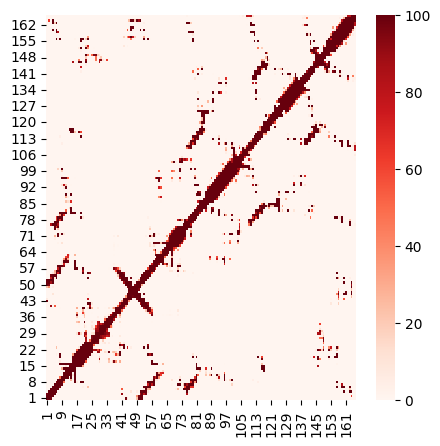

In [12]:
#Plot the contact matrix
fig = plt.figure(figsize=(5,5))
sns.heatmap(contact_matrix,cmap="Reds",vmin=0,vmax=100)
#Invert the y axis
plt.gca().invert_yaxis()
#Set thicks to 10
plt.show()



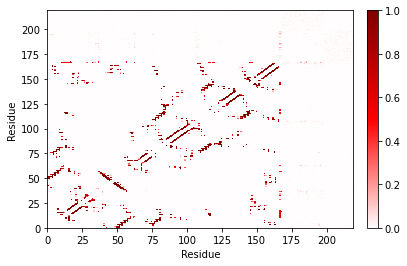

# Test LifeTime Analysis

In [13]:
u = mda.Universe("/martini/rubiz/thylakoid/Lipid_Fingerprint_Analysis/contact_map/kras.pdb","/martini/rubiz/thylakoid/Lipid_Fingerprint_Analysis/contact_map/kras.xtc")
#Change resname UNL to O2
#u.atoms.residues.resnames = np.where(u.atoms.residues.resnames == 'UNL', 'O2', u.atoms.residues.resnames)
sel1 = u.select_atoms('protein')
sel2 = u.select_atoms('protein')
print(sel1.n_residues)
print(sel2.n_residues)

# Test pairwise contacts
n_frames = u.trajectory.n_frames
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 4.5, group_by1="resids", group_by2="resids")

contact_pairs_matrix_list = contact_matrix_obj.calculate_contact_pairs_matrix_per_observation(n_frames-1)
contact_pairs_matrix = contact_pairs_matrix_list[0]
#display(contact_pairs_matrix)

166
166
Shape of contact pairs matrix:  27556 101
Saving matrix at frame: 100
Number of contact matrices saved:  1


In [14]:
display(contact_pairs_matrix.head())    

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,...,166_157,166_158,166_159,166_160,166_161,166_162,166_163,166_164,166_165,166_166
0,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
1,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
2,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
3,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
4,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True


In [15]:
lifetimes = extract_lifetimes(contact_pairs_matrix)


In [16]:
labels = contact_pairs_matrix.columns
# Plot lifetimes for each column

# Function to safely calculate statistics for potentially empty arrays
def safe_stat(lifetime_array, stat_func, default_value=np.nan):
    """Calculate statistics safely, returning default_value for empty arrays"""
    if len(lifetime_array) == 0:
        return default_value
    return stat_func(lifetime_array)

# New dataframe with labels as index and columns: mean, std, min, max, median, n_counts
lifetimes_df = pd.DataFrame({
    'mean': [safe_stat(lifetime, np.mean) for lifetime in lifetimes],
    'std': [safe_stat(lifetime, np.std) for lifetime in lifetimes],
    'min': [safe_stat(lifetime, np.min) for lifetime in lifetimes],
    'max': [safe_stat(lifetime, np.max) for lifetime in lifetimes],
    'median': [safe_stat(lifetime, np.median) for lifetime in lifetimes],
    'n_counts': [len(lifetime) for lifetime in lifetimes]
}, index=labels)


In [17]:
#Sort by mean
lifetimes_df = lifetimes_df.sort_values(by='mean', ascending=False)

In [ ]:
#display(lifetimes_df)

# Test Particle distribution over time

In [ ]:
def time_to_frame(trajectory, time_ns):
    """Convert time in nanoseconds to frame number"""
    time_ps = time_ns * 1000  # Convert ns to ps
    dt = trajectory.dt  # Time step in ps
    
    # Go to first frame to get start time
    trajectory[0]
    start_time = trajectory.time
    
    # Calculate frame number
    frame_number = int((time_ps - start_time) / dt)
    return max(0, min(frame_number, trajectory.n_frames - 1))

In [46]:
#https://figshare.com/s/453b1b215cf2f9270769 
u = mda.Universe("/martini/rubiz/thylakoid/Lipid_Fingerprint_Analysis/contact_map/kras.pdb","/martini/rubiz/thylakoid/Lipid_Fingerprint_Analysis/contact_map/kras.xtc")
sel1 = u.select_atoms('protein')
sel2 = u.select_atoms('resname CL')
print(sel1.n_residues)
print(sel2.n_residues)
selections = [sel1, sel2]
start_time = u.trajectory.time
time_steps = [0, 25, 50, 75, 100]

frames = []
for time_step in time_steps:
    frame = time_to_frame(u.trajectory, time_step)
    frames.append(frame)

166
21
Time: 0 ns corresponds to frame: 0
Time: 25 ns corresponds to frame: 25
Time: 50 ns corresponds to frame: 50
Time: 75 ns corresponds to frame: 75
Time: 100 ns corresponds to frame: 100


In [47]:
positions = []
for sel in selections:
    pos = []
    for frame in frames:
        u.trajectory[frame]
        pos.append(sel.atoms.positions)
    positions.append(pos)

In [54]:
# Get min_x, max_x, min_y, max_y from the positions
# Flatten the nested list structure: positions[selection][frame]
all_positions = [pos for selection_positions in positions for pos in selection_positions]
min_x = min(np.min(pos[:, 0]) for pos in all_positions)
max_x = max(np.max(pos[:, 0]) for pos in all_positions)
min_y = min(np.min(pos[:, 1]) for pos in all_positions)
max_y = max(np.max(pos[:, 1]) for pos in all_positions)

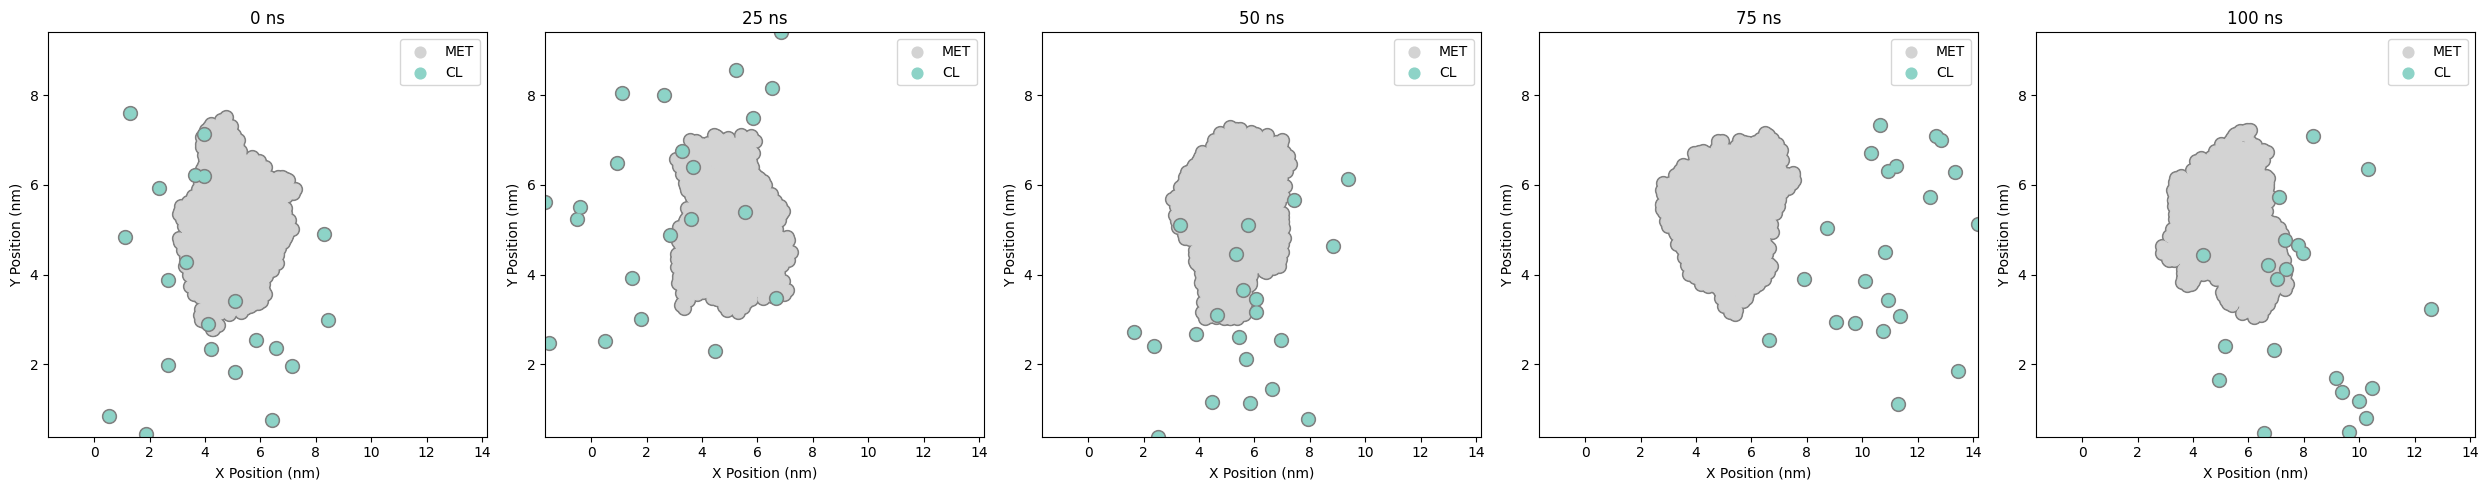

In [72]:
# Scattered plot with len(frames) subplots showing both selections
pallette = sns.color_palette("Set3", n_colors=len(selections))
fig, axes = plt.subplots(1, len(frames), figsize=(5*len(frames), 5))

# Ensure axes is always a list for consistent indexing
if len(frames) == 1:
    axes = [axes]

colors_selections = ["lightgrey", pallette[0]]

for j, (frame, time_step) in enumerate(zip(frames, time_steps)):
    for i, sel in enumerate(selections):
        p = positions[i][j]
        axes[j].scatter(p[:, 0], p[:, 1], color='grey', s=100, alpha=1)
        axes[j].scatter(p[:, 0], p[:, 1], color=colors_selections[i], s=60, label=f'{sel.resnames[0]}', alpha=1)
    
    axes[j].set_title(f'{time_step} ns')
    axes[j].set_xlabel('X Position (nm)')
    axes[j].set_ylabel('Y Position (nm)')
    axes[j].set_xlim(min_x, max_x)
    axes[j].set_ylim(min_y, max_y)
    x_ticks = axes[j].get_xticks()
    x_ticks_nm = [f"{x_tick / 10:.0f}" for x_tick in x_ticks]
    axes[j].set_xticklabels(x_ticks_nm)
    y_ticks = axes[j].get_yticks()
    y_ticks_nm = [f"{y_tick / 10:.0f}" for y_tick in y_ticks]
    axes[j].set_yticklabels(y_ticks_nm)

    axes[j].legend()

plt.tight_layout()
plt.show()


# Gobal variables

# 🔵 Contact Analysis 

## Chain 4 proteins

In [22]:
gro = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_4/initial_fit.pdb"
xtc = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_4/aligned.xtc"
u = mda.Universe(gro, xtc)

sel1 = u.select_atoms('chainID A B')
sel2 = u.select_atoms('chainID 4 and not resname CLA CLB CHL *HG* PLQ PL9 *GG* *SQ* *PG* LUT VIO XAT NEO NEX W2 HOH BCR')
print(sel1.n_residues)
print(sel2.n_residues)
#Print the number of frames
n_frames = len(u.trajectory)
print("Number of frames: ", n_frames)

424
210
Number of frames:  35053


In [23]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resids")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)


Saving matrix at frame: 35052
Number of contact matrices saved:  1


In [ ]:
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_4/contact_matrix_protein_5000ns.csv')


In [ ]:
#Load the contact matrix
contact_matrix1 = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_4/contact_matrix_protein_5000ns.csv', index_col=0)

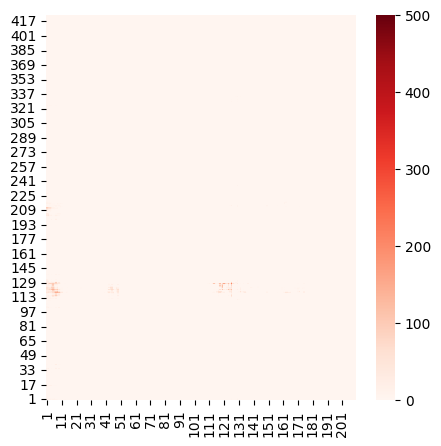

In [ ]:
#Plot matrix
fig = plt.figure(figsize=(5,5))
sns.heatmap(contact_matrix1, cmap="Reds", vmin=0, vmax=500)
#Invert the y axis
plt.gca().invert_yaxis()
plt.show()


In [ ]:
#Get the stats for PsbS
stats1 = contact_matrix1.T.describe()

In [ ]:
stats1

## Chain 4 cofactors

In [ ]:
sel1 = u.select_atoms('chainID A B')
sel2 = u.select_atoms('resname CLA CLB CHL PLQ PL9 LUT VIO XAT NEO NEX BCR')
print(sel1.n_residues)
print(sel2.n_residues)
n

424
14


In [ ]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resnames")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_pai
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_4/contact_matrix_cofactors_5000ns.csv')


In [ ]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resids")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_4/contact_matrix_cofactors_resids_5000ns.csv')

In [ ]:
#Load the contact matrix
contact_matrix2 = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_4/contact_matrix_cofactors_5000ns.csv', index_col=0)

In [ ]:
#Print the stadistics of the contact matrix
contact_matrix2.describe()

,BCR,CHL,CLA,LUT,XAT
count,424.000000,424.000000,424.000000,424.000000,424.000000
mean,4.589623,2.228774,11.266509,10.436321,14.474057
std,9.571998,16.034597,66.508445,28.809978,34.580967
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.000000,0.000000,0.000000,7.000000,10.000000
max,60.000000,224.000000,683.000000,315.000000,252.000000


## Chain s proteins

In [ ]:
gro = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_s/initial_fit.pdb"
xtc = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_s/aligned.xtc"
u = mda.Universe(gro, xtc)

sel1 = u.select_atoms('chainID A B')
sel2 = u.select_atoms('chainID s and not resname CLA CLB CHL *HG* PLQ PL9 *GG* *SQ* *PG* LUT VIO XAT NEO NEX W2 HOH BCR')
print(sel1.n_residues)
print(sel2.n_residues)
n_frames = len(u.trajectory)
print("Number of frames: ", n_frames)

424
244
Number of frames:  35902


In [ ]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resids")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_s/contact_matrix_protein_5000ns.csv')



In [ ]:
#Load the contact matrix
contact_matrix3 = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_s/contact_matrix_protein_5000ns.csv', index_col=0)

In [ ]:
#Print max value
print("Max value of contact matrix 3: ", contact_matrix3.max().max())

Max value of contact matrix 3:  875.0


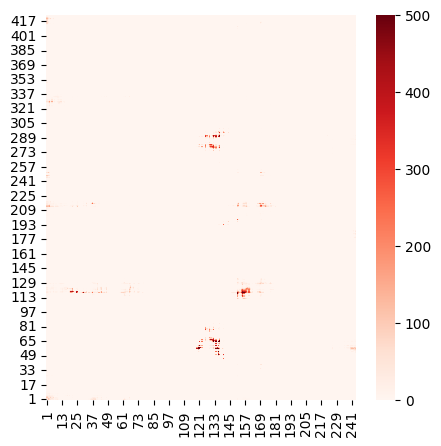

In [ ]:
#Plot matrix
fig = plt.figure(figsize=(5,5))
sns.heatmap(contact_matrix3, cmap="Reds", vmin=0, vmax=500)
#Invert the y axis
plt.gca().invert_yaxis()
plt.show()


## Chain s cofactors

In [ ]:
sel1 = u.select_atoms('chainID A B')
sel2 = u.select_atoms('resname CLA CLB CHL PLQ PL9 LUT VIO XAT NEO NEX BCR')
print(sel1.n_residues)
print(sel2.n_residues)

424
16


In [ ]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resnames")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_s/contact_matrix_cofactors_5000ns.csv')

In [ ]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resids")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_s/contact_matrix_cofactors_resids_5000ns.csv')

In [ ]:
#Load the contact matrix
contact_matrix3 = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_s/contact_matrix_cofactors_5000ns.csv', index_col=0)

In [ ]:
#Print the stadistics of the contact matrix
contact_matrix3.describe()

,CHL,CLA,LUT,NEX
count,424.000000,424.000000,424.000000,424.000000
mean,44.580189,12.547170,41.900943,103.356132
std,131.723484,66.379257,67.149912,188.255053
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,9.000000,15.000000
75%,2.000000,0.000000,58.500000,94.500000
max,845.000000,853.000000,484.000000,954.000000


## Chain R proteins

In [ ]:
gro = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_r/initial_fit.pdb"
xtc = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_r/aligned.xtc"
u = mda.Universe(gro, xtc)

sel1 = u.select_atoms('chainID A B')
sel2 = u.select_atoms('chainID r and not resname CLA CLB CHL *HG* PLQ PL9 *GG* *SQ* *PG* LUT VIO XAT NEO NEX W2 HOH BCR')
print(sel1.n_residues)
print(sel2.n_residues)
n_frames = len(u.trajectory)
print("Number of frames: ", n_frames)

424
246
Number of frames:  36001


In [ ]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resids")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_r/contact_matrix_protein_5000ns.csv')

In [ ]:
#Load the contact matrix
contact_matrix3 = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_r/contact_matrix_protein_5000ns.csv', index_col=0)

In [ ]:
#Print max value
print("Max value of contact matrix 3: ", contact_matrix3.max().max())

Max value of contact matrix 3:  786.0


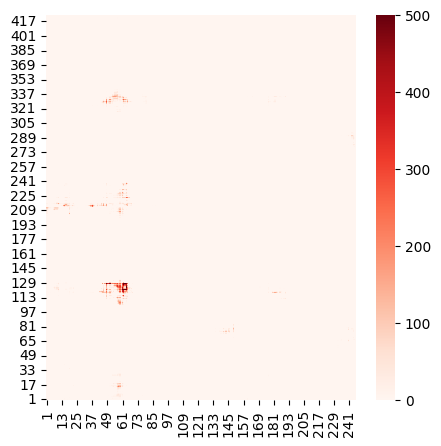

In [ ]:
#Plot matrix
fig = plt.figure(figsize=(5,5))
sns.heatmap(contact_matrix3, cmap="Reds", vmin=0, vmax=500)
#Invert the y axis
plt.gca().invert_yaxis()
plt.show()

## Chain r cofactors

In [ ]:
sel1 = u.select_atoms('chainID A B')
sel2 = u.select_atoms('resname CLA CLB CHL PLQ PL9 LUT VIO XAT NEO NEX W2 BCR')
print(sel1.n_residues)
print(sel2.n_residues)

424
17


In [ ]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resnames")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_r/contact_matrix_cofactors_5000ns.csv')

In [ ]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resids")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_r/contact_matrix_cofactors_resids_5000ns.csv')

In [ ]:
#Load the contact matrix
contact_matrix3 = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_r/contact_matrix_cofactors_5000ns.csv', index_col=0)

In [ ]:
#Print the stadistics of the contact matrix
contact_matrix3.describe()

,CHL,CLA,LUT,NEX,XAT
count,424.000000,424.000000,424.000000,424.000000,424.000000
mean,3.084906,23.077830,25.316038,11.820755,18.596698
std,15.021100,72.969349,43.436474,26.650632,53.407440
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,4.000000,0.000000,0.000000
75%,0.000000,0.000000,34.250000,7.000000,8.000000
max,137.000000,664.000000,250.000000,167.000000,425.000000


## Chain c

In [ ]:
# Chain R
gro = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/initial_fit.pdb"
xtc = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/aligned.xtc"
u = mda.Universe(gro, xtc)

sel1 = u.select_atoms('chainID A B')
sel2 = u.select_atoms('chainID c and not resname CLA CLB CHL *HG* PLQ PL9 *DG* *MG* *SQ* *PG* LUT VIO XAT NEO NEX W2 HOH BCR')
print(sel1.n_residues)
print(sel2.n_residues)
n_frames = len(u.trajectory)
print("Number of frames: ", n_frames)




424
473
Number of frames:  36001


In [ ]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resids")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/contact_matrix_protein_5000ns.csv')

In [ ]:
#Load the contact matrix
contact_chainc_protein = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/contact_matrix_protein_5000ns.csv', index_col=0)
#Print max value
print("Max value of contact matrix 3: ", contact_matrix3.max().max())

Max value of contact matrix 3:  710.0


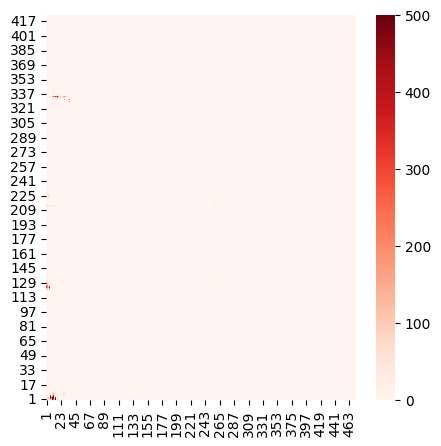

In [ ]:
#Plot matrix
fig = plt.figure(figsize=(5,5))
sns.heatmap(contact_matrix3, cmap="Reds", vmin=0, vmax=500)
#Invert the y axis
plt.gca().invert_yaxis()
plt.show()

## Chain c cofactors

In [ ]:
sel2 = u.select_atoms('resname CLA CLB CHL PLQ PL9 LUT VIO XAT NEO NEX BCR *HG* *DG* *MG* *SQ* *PG* W2 HOH')
#Per resid, used for bfactors
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resids")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/contact_matrix_cofactors_resids_5000ns.csv')

In [ ]:
#Load the contact matrix
contact_cofactors_resids = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/contact_matrix_cofactors_resids_5000ns.csv', index_col=0)
#Print the stadistics of the contact matrix
contact_cofactors_resids.describe()

,501,502,503,504,505,506,507,508,509,510,...,1213,1214,1215,1216,1217,1218,1219,1220,1221,2630
count,424.0,424.0,424.0,424.000000,424.000000,424.000000,424.0,424.000000,424.0,424.0,...,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,0.0,0.0,0.0,0.448113,0.054245,0.018868,0.0,0.106132,0.0,0.0,...,1.834906,2.207547,2.122642,3.000000,3.042453,2.441038,1.818396,2.233491,1.811321,23.900943
std,0.0,0.0,0.0,3.707656,0.513994,0.388514,0.0,1.342367,0.0,0.0,...,2.528534,2.846646,3.608377,5.313349,7.396126,3.372299,3.003944,3.528300,2.989701,53.929861
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000,18.250000
max,0.0,0.0,0.0,49.000000,8.000000,8.000000,0.0,25.000000,0.0,0.0,...,14.000000,16.000000,22.000000,36.000000,51.000000,18.000000,15.000000,22.000000,17.000000,392.000000


# 🔵 Save bfactors in PDB

In [ ]:
#Read all the contact matrices
contact_chain4_protein = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/csv_files/contact_matrix_protein_5000ns.csv', index_col=0)
contact_chain4_cofactors = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_4/contact_matrix_cofactors_5000ns.csv', index_col=0)
contact_chain4_cofactors_resids = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_4/contact_matrix_cofactors_resids_5000ns.csv', index_col=0)
#Read all the contact matrices
contact_chains_protein = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_s/contact_matrix_protein_5000ns.csv', index_col=0)
contact_chains_cofactors = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_s/contact_matrix_cofactors_5000ns.csv', index_col=0)
contact_chains_cofactors_resids = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_s/contact_matrix_cofactors_resids_5000ns.csv', index_col=0)
#Read all the contact matrices
contact_chainr_protein = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_r/contact_matrix_protein_5000ns.csv', index_col=0)
contact_chainr_cofactors = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_r/contact_matrix_cofactors_5000ns.csv', index_col=0)
contact_chainr_cofactors_resids = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_r/contact_matrix_cofactors_resids_5000ns.csv', index_col=0)
contact_chainc_protein = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/contact_matrix_protein_5000ns.csv', index_col=0)
contact_chainc_cofactors = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/contact_matrix_cofactors_5000ns.csv', index_col=0)
contact_chainc_cofactors_resids = pd.read_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/contact_matrix_cofactors_resids_5000ns.csv', index_col=0)



In [ ]:
resids_psbs = contact_chain4_protein.index.values

#Chain 4
contact_chain4_psbs = contact_chain4_protein.sum(axis=1).values #Sum the rows, to get PsbS contacts
contact_chain4 = contact_chain4_protein.sum(axis=0).values #Sum the columns, to chain contacts
resids_chain4 = contact_chain4_protein.columns.values
contact_chain4_cofactors_psbs = contact_chain4_cofactors_resids.sum(axis=1).values #Sum the rows, to get PsbS contacts
resids_chain4_cofactors = contact_chain4_cofactors_resids.columns.values
contact_chain4_cofactors = contact_chain4_cofactors_resids.sum(axis=0).values #Sum the columns, to chain contacts

#Chain S
contact_chains_psbs = contact_chains_protein.sum(axis=1).values #Sum the rows, to get PsbS contacts
contact_chains = contact_chains_protein.sum(axis=0).values #Sum the columns, to chain contacts
resids_chains = contact_chains_protein.columns.values
contact_chains_cofactors_psbs = contact_chains_cofactors_resids.sum(axis=1).values #Sum the rows, to get PsbS contacts
resids_chains_cofactors = contact_chains_cofactors_resids.columns.values
contact_chains_cofactors = contact_chains_cofactors_resids.sum(axis=0).values #Sum the columns, to chain contacts
#Chain R
contact_chainr_psbs = contact_chainr_protein.sum(axis=1).values #Sum the rows, to get PsbS contacts
contact_chainr = contact_chainr_protein.sum(axis=0).values #Sum the columns, to chain contacts
resids_chainr = contact_chainr_protein.columns.values
contact_chainr_cofactors_psbs = contact_chainr_cofactors_resids.sum(axis=1).values #Sum the rows, to get PsbS contacts
resids_chainr_cofactors = contact_chainr_cofactors_resids.columns.values
contact_chainr_cofactors = contact_chainr_cofactors_resids.sum(axis=0).values #Sum the columns, to chain contacts
#Chain C
contact_chainc_psbs = contact_chainc_protein.sum(axis=1).values #Sum the rows, to get PsbS contacts
contact_chainc = contact_chainc_protein.sum(axis=0).values #Sum the columns, to chain contacts
resids_chainc = contact_chainc_protein.columns.values
contact_chainc_cofactors_psbs = contact_chainc_cofactors_resids.sum(axis=1).values #Sum the rows, to get PsbS contacts
resids_chainc_cofactors = contact_chainc_cofactors_resids.columns.values
contact_chainc_cofactors = contact_chainc_cofactors_resids.sum(axis=0).values #Sum the columns, to chain contacts


In [ ]:
#Reference files
ref_gro = "/martini/rubiz/Github/PsbS_Binding_Site/3_reference_proteins/5XNL.pdb"
#chains = ['4', 's', 'r', 'c']  # List of chains to process
chains = ['s']
# Save the AA chains with B-factors
u_chain = mda.Universe(ref_gro)
for chain in chains:
    #Saving info in CHAIN 4, S, R, C

    # Select the universe for the specific chain
    #sel1 = u_chain.select_atoms(f'chainID {chain}')
    sel1 = u_chain.select_atoms(f'chainID {chain}')

    #Call variable with the contact matrix for the cofactors
    var_bfactors_chain = f"contact_chain{chain}"
    var_resids_chain = f"resids_chain{chain}"
    var_bfactors_chain_cofactors = f"contact_chain{chain}_cofactors"
    var_resids_chain_cofactors = f"contact_chain{chain}_cofactors_resids"

    bfactors_chain = globals()[var_bfactors_chain]
    print(f"Max value of contact_chain{chain}: ", bfactors_chain.max())
    resids_chain = globals()[var_resids_chain]
    bfactors_chain_cofactors = globals()[var_bfactors_chain_cofactors]
    #print(bfactors_chain_cofactors)
    resids_chain_cofactors = globals()[var_resids_chain_cofactors]

    # Assign B-factors to the universe for the specific chain
    u_chain = assign_bfactor_to_universe(u_chain, resids_chain, bfactors_chain)
    u_chain = assign_bfactor_to_universe(u_chain, resids_chain_cofactors, bfactors_chain_cofactors)

    # Save the universe to a PDB file
    output_filename = f'/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_{chain}/contacts_5000ns.pdb'
    sel = u_chain.select_atoms(f'chainID {chain}')
    save_universe_to_pdb(sel, output_filename)
    print(f"B-factors assigned and saved for chain {chain} in {output_filename}")



Max value of contact_chains:  5800.0
Universe saved to /martini/rubiz/interaction_partner_paper/4_pairs/analysis/chain_s/contacts_2000ns.pdb
B-factors assigned and saved for chain s in /martini/rubiz/interaction_partner_paper/4_pairs/analysis/chain_s/contacts_2000ns.pdb


In [ ]:
psbs_gro = "/martini/rubiz/Github/PsbS_Binding_Site/3_reference_proteins/psbs/psbs_7_5_dimer.pdb"
u_psbs = mda.Universe(psbs_gro)

chains = ['4', 's', 'r', 'c']
#Now for PsbS
for chain in chains:
    #Call variable with the contact matrix for the cofactors
    var_bfactors_chain = f"contact_chain{chain}_psbs"
    var_bfactors_chain_cofactors = f"contact_chain{chain}_cofactors_psbs"
    var_resids_chain = f"resids_psbs"

    #Sum bfactors chain and cofactors
    bfactors_chain_psbs = globals()[var_bfactors_chain]
    bfactors_chain_cofactors_psbs = globals()[var_bfactors_chain_cofactors]
    resids_chain = globals()[var_resids_chain]
    #print(bfactors_chain_cofactors_psbs)
    #Sum the two arrays
    bfactors_chain = bfactors_chain_psbs + bfactors_chain_cofactors_psbs
    #bfactors_chain = bfactors_chain_psbs 

    print(f"Max value of contact_chain{chain}_psbs: ", bfactors_chain.max())

    # Assign B-factors to the universe for the specific chain
    u_psbs = assign_bfactor_to_universe(u_psbs, resids_chain, bfactors_chain)

    # Save the universe to a PDB file
    output_filename = f'/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_{chain}/psbs_chain{chain}_contacts_5000ns.pdb'

    save_universe_to_pdb(u_psbs, output_filename)
    print(f"B-factors assigned and saved for PsbS chain {chain} in {output_filename}")



Max value of contact_chain4_psbs:  2739.0
Universe saved to /martini/rubiz/interaction_partner_paper/4_pairs/analysis/chain_4/psbs_chain4_contacts_2000ns.pdb
B-factors assigned and saved for PsbS chain 4 in /martini/rubiz/interaction_partner_paper/4_pairs/analysis/chain_4/psbs_chain4_contacts_2000ns.pdb
Max value of contact_chains_psbs:  8962.0
Universe saved to /martini/rubiz/interaction_partner_paper/4_pairs/analysis/chain_s/psbs_chains_contacts_2000ns.pdb
B-factors assigned and saved for PsbS chain s in /martini/rubiz/interaction_partner_paper/4_pairs/analysis/chain_s/psbs_chains_contacts_2000ns.pdb
Max value of contact_chainr_psbs:  6642.0
Universe saved to /martini/rubiz/interaction_partner_paper/4_pairs/analysis/chain_r/psbs_chainr_contacts_2000ns.pdb
B-factors assigned and saved for PsbS chain r in /martini/rubiz/interaction_partner_paper/4_pairs/analysis/chain_r/psbs_chainr_contacts_2000ns.pdb
Max value of contact_chainc_psbs:  5620.0
Universe saved to /martini/rubiz/interactio

# 🔵 Particle distribution over time

# 🔵 Lifetime analysis

In [ ]:
# Chain c cofactors
gro = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/initial_fit.pdb"
xtc = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/aligned.xtc"
u = mda.Universe(gro, xtc)
sel1 = u.select_atoms('chainID A B')
sel2 = u.select_atoms('resname CLA CLB CHL PLQ PL9 LUT VIO XAT NEO NEX BCR')
n_frames = len(u.trajectory)
print("Number of frames: ", n_frames)
print(sel1.n_residues)
print(sel2.n_residues)
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resnames")
contact_matrix_list = contact_matrix_obj.calculate_contact_pairs_matrix_per_observation(n_frames=n_frames-1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_c/contact_boolean_cofactors_5000ns.csv')

NameError: name 'mda' is not defined